In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as ssd
from scipy.spatial import distance
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

In [17]:
# Calculate JSD metric
def f_js(x, y):
    return distance.jensenshannon(x, y)

# Function calculates NN=5 distances
def NN_dist(data=None, lat_lis=None, lon_lis=None):

    # In km
    r = 6371.0088

    data = data.dropna()
    mmsi = data.mmsi
    data = data.sort_values('mmsi')
    lat_lis = data['lat']
    lon_lis = data['lon']
    timestamp = data['hour'].iat[0]

    lat_mtx = np.array([lat_lis]).T * np.pi / 180
    lon_mtx = np.array([lon_lis]).T * np.pi / 180

    cos_lat_i = np.cos(lat_mtx)
    cos_lat_j = np.cos(lat_mtx)
    cos_lat_J = np.repeat(cos_lat_j, len(lat_mtx), axis=1).T

    lat_Mtx = np.repeat(lat_mtx, len(lat_mtx), axis=1).T
    cos_lat_d = np.cos(lat_mtx - lat_Mtx)

    lon_Mtx = np.repeat(lon_mtx, len(lon_mtx), axis=1).T
    cos_lon_d = np.cos(lon_mtx - lon_Mtx)

    mtx = r * np.arccos(cos_lat_d - cos_lat_i*cos_lat_J*(1 - cos_lon_d))

    # Build data.frame
    matdat = pd.DataFrame(mtx)
    matdat.columns = mmsi[:]
    matdat = matdat.set_index(mmsi[:])

    # Stack and form three column data.frame
    tmatdat = matdat.stack()
    lst = tmatdat.index.tolist()
    vessel_A = pd.Series([item[0] for item in lst])
    vessel_B = pd.Series([item[1] for item in lst])
    distance = tmatdat.values

    # Get lat/lon per mmsi
    posdat = data[['mmsi', 'lat', 'lon']]
    posdat = posdat.sort_values('mmsi')

    # Build data frame
    odat = pd.DataFrame({'timestamp': timestamp, 'vessel_A': vessel_A,
                         'vessel_B': vessel_B, 'distance': distance})
    odat = odat.sort_values(['vessel_A', 'distance'])

    # Get 05-NN
    odat = odat.sort_values('distance').groupby(
        'vessel_A', as_index=False).nth([0, 1, 2, 3, 4, 5])
    odat = odat.sort_values(['vessel_A', 'distance'])

    # Merge in vessel_B lat/lon
    posdat.columns = ['mmsi', 'vessel_B_lat', 'vessel_B_lon']
    odat = odat.merge(posdat, how='left', left_on='vessel_B', right_on='mmsi')

    # Merge in vessel_A lat/lon
    posdat.columns = ['mmsi', 'vessel_A_lat', 'vessel_A_lon']
    odat = odat.merge(posdat, how='left', left_on='vessel_A', right_on='mmsi')

    odat['NN'] = odat.groupby(['vessel_A'], as_index=False).cumcount()
    odat = odat.reset_index(drop=True)
    odat = odat[['timestamp', 'vessel_A', 'vessel_B', 'vessel_A_lat',
                 'vessel_A_lon', 'vessel_B_lat', 'vessel_B_lon', 'NN', 'distance']]
    odat = odat.sort_values(['vessel_A', 'NN'])

    # Data check: Ensure have 5 NN
    nn5 = odat.sort_values('NN').groupby('vessel_A').tail(1)
    
    nn5 = nn5[nn5['NN'] == 5]
    
    unique_nn5 = nn5['vessel_A'].unique()

    odat = odat[odat.vessel_A.isin(unique_nn5)]

    return odat

# Calculate distance matrix
def jsd_matrix(dat, interval, NN=0):
    if interval == 'dayhour':
        dat = dat.groupby(['vessel_A', 'timestamp'],
                          as_index=False)['distance'].mean()
        x = []

        gb = dat.groupby(['timestamp'])['distance']
        lst = [gb.get_group(x) for x in gb.groups]
        x = []
        for i in range(len(lst)):
            for j in range(len(lst)):
                x += [(i, j, f_js(lst[i], lst[j]))]

        distMatrix = pd.DataFrame(x).pivot(index=0, columns=1, values=2)
        distMatrix = np.matrix(distMatrix)

    return (distMatrix)

In [18]:
# Brownian motion 2-dimension simulation data
# 100 vessels
# location centered around 0 
# movement sd = 0.01
# N = Number of hours

N = 31*24

indat = pd.DataFrame()
for i in range(0, 100):

    # Get random sample data
    lat_dis = np.random.normal(0, .01, N)
    lon_dis = np.random.normal(0, .01, N)
    
    # Cumsum to get movement through space
    lat = np.cumsum(lat_dis)
    lon = np.cumsum(lon_dis)

    # Data frame to merge with indat
    outdat = pd.DataFrame({"hour": range(N),
                            "mmsi": i,
                            "lon": lon,
                            "lat": lat})
    # merge dat
    indat = pd.concat([indat, outdat])

# Sample data
indat.head()

,hour,mmsi,lon,lat
0,0,0,0.001021,0.004714
1,1,0,0.012971,-0.007195
2,2,0,0.010192,0.007132
3,3,0,0.009670,0.004005
4,4,0,0.013207,-0.003201


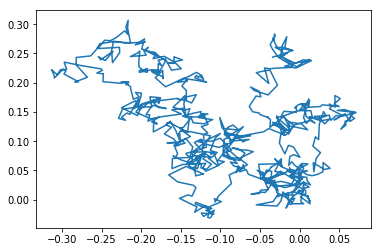

In [19]:
# Plot single vessel
test = indat[indat['mmsi'] == 0]
plt.plot(test['lon'], test['lat'])

In [27]:
# Get NN distances for each vessel in each hour
odat = indat.groupby('hour', as_index=False).apply(NN_dist)

# Print distance range
print(f"Min Distance: {min(odat['distance'])}  Max Distance: {max(odat['distance'])}")

# Remove first observation vessel_A = vessel_A distance = 0
odat = odat[odat['distance'] != 0]

# Subset out event day and shock system
# Day 1 - 13
dis1 = odat[odat['timestamp'] <= 288]

# Day 14 - 17
dis2 = odat[(odat['timestamp'] >= 289) & (odat['timestamp'] <= 407)]

# Day 18 - 31
dis3 = odat[odat['timestamp'] >= 408]

# Shock system using abs value of normal distribution during event
shock = np.abs(np.random.normal(50, 5, len(dis2)))

# Output of shock values
print(min(shock), max(shock))

# Apply shock
dis2.loc[:, 'distance'] = dis2.loc[:, 'distance'] + shock
      
# Merge data back
dis = pd.concat([dis1, dis2, dis3])

# Get average NN distance for each vessel in each day
dis = dis.groupby(['vessel_A', 'timestamp'], as_index=False)['distance'].mean()

Min Distance: 0.0  Max Distance: 61.42407748778972
28.854772202995875 70.82828541937812


/home/server/pi/homes/woodilla/.conda/envs/baseDS_env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
dis1.head()

timestamp  vessel_A  vessel_B  vessel_A_lat  vessel_A_lon  vessel_B_lat  \
0 1          0         0         3      0.004714      0.001021      0.006046   
  2          0         0        60      0.004714      0.001021      0.004756   
  3          0         0        56      0.004714      0.001021      0.001364   
  4          0         0         9      0.004714      0.001021      0.002213   
  5          0         0        90      0.004714      0.001021      0.003530   

     vessel_B_lon  NN  distance  
0 1      0.001113   1  0.148397  
  2      0.003885   2  0.318544  
  3     -0.000269   3  0.399139  
  4      0.004457   4  0.472560  
  5      0.005328   5  0.496714

In [34]:
dis2.head() 

timestamp  vessel_A  vessel_B  vessel_A_lat  vessel_A_lon  \
289 1        289         0         3      0.129052     -0.180289   
    2        289         0        45      0.129052     -0.180289   
    3        289         0        56      0.129052     -0.180289   
    4        289         0        82      0.129052     -0.180289   
    5        289         0        24      0.129052     -0.180289   

       vessel_B_lat  vessel_B_lon  NN   distance  
289 1      0.142521     -0.203004   1  53.352434  
    2      0.160817     -0.155565   2  56.651772  
    3      0.107534     -0.131258   3  50.425518  
    4      0.078345     -0.116987   4  54.661767  
    5      0.104953     -0.264770   5  60.096051

In [35]:
dis3.head()

timestamp  vessel_A  vessel_B  vessel_A_lat  vessel_A_lon  \
408 1        408         0        75      0.248133     -0.180401   
    2        408         0        66      0.248133     -0.180401   
    3        408         0        10      0.248133     -0.180401   
    4        408         0        90      0.248133     -0.180401   
    5        408         0         6      0.248133     -0.180401   

       vessel_B_lat  vessel_B_lon  NN   distance  
408 1      0.245541     -0.098469   1   9.114851  
    2      0.159701     -0.172468   2   9.872690  
    3      0.154676     -0.220205   3  11.295200  
    4      0.200532     -0.086256   4  11.730395  
    5      0.136398     -0.182851   5  12.427368

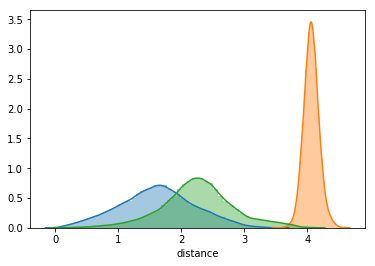

In [36]:
# Distribution plots
sns.distplot(np.log(1 + dis1['distance']))
sns.distplot(np.log(sdis))
sns.distplot(np.log(1 + dis3['distance']))

In [30]:
# Calculate JSD matrix
dmat = jsd_matrix(dis, "dayhour")

# Check matrix
print(dmat)

[[0.         0.19634808 0.22235299 ... 0.29338634 0.28822691 0.28742655]
 [0.19634808 0.         0.16826111 ... 0.27022486 0.26585199 0.26423677]
 [0.22235299 0.16826111 0.         ... 0.27685658 0.27060871 0.27034726]
 ...
 [0.29338634 0.27022486 0.27685658 ... 0.         0.02587014 0.03616361]
 [0.28822691 0.26585199 0.27060871 ... 0.02587014 0.         0.02252438]
 [0.28742655 0.26423677 0.27034726 ... 0.03616361 0.02252438 0.        ]]


# Metric-MDS 5-Dimensions

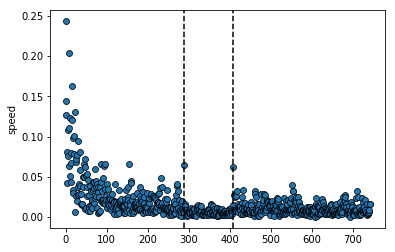

In [37]:
# Metric-MDS 5-dimensions
nmds = MDS(n_components=5, metric=True, dissimilarity='precomputed')
nmds_dat = nmds.fit_transform(dmat)

ndat = pd.DataFrame({"x": nmds_dat[:, 0], "y": nmds_dat[:, 1]})

ndat['x2'] = ndat['x'].shift(-1)
ndat['y2'] = ndat['y'].shift(-1)
ndat.head()
ndat['distance'] = np.sqrt( (ndat['x'] - ndat['x2'])**2 + (ndat['y'] - ndat['y2'])**2 )

# Calculate speed
ndat['speed'] = ndat['distance']/1
ndat.head()

# Plot speed
plt = sns.scatterplot(x=range(len(ndat)) ,y=ndat['speed'], edgecolor="black")
plt.axvline(289, ls='--', color='black')
plt.axvline(407, ls='--', color='black')

# nMDS 5-Dimensions

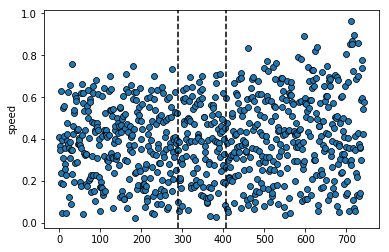

In [38]:
# Nonmetric-MDS 5-dimensions
nmds = MDS(n_components=5, metric=False, dissimilarity='precomputed')
nmds_dat = nmds.fit_transform(dmat)

ndat = pd.DataFrame({"x": nmds_dat[:, 0], "y": nmds_dat[:, 1]})

ndat['x2'] = ndat['x'].shift(-1)
ndat['y2'] = ndat['y'].shift(-1)
ndat.head()
ndat['distance'] = np.sqrt( (ndat['x'] - ndat['x2'])**2 + (ndat['y'] - ndat['y2'])**2 )

# Calculate speed
ndat['speed'] = ndat['distance']/1
ndat.head()

# Plot speed
plt = sns.scatterplot(x=range(len(ndat)) ,y=ndat['speed'], edgecolor="black")
plt.axvline(289, ls='--', color='black')
plt.axvline(407, ls='--', color='black')

# nMDS ISO Mapping 5-dimensions

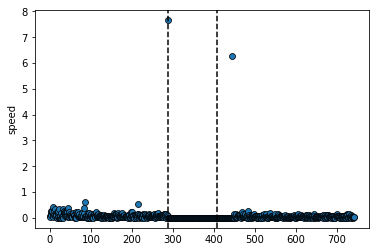

In [39]:
# nMDS using ISO Mapping
nmds = Isomap(n_components=5)
nmds_dat = nmds.fit_transform(dmat)
ndat = pd.DataFrame({"x": nmds_dat[:, 0], "y": nmds_dat[:, 1]})

ndat['x2'] = ndat['x'].shift(-1)
ndat['y2'] = ndat['y'].shift(-1)

ndat['distance'] = np.sqrt( (ndat['x'] - ndat['x2'])**2 + (ndat['y'] - ndat['y2'])**2 )

# Calculate speed
ndat['speed'] = ndat['distance']/1


# Plot speed
plt = sns.scatterplot(x=range(len(ndat)) ,y=ndat['speed'], edgecolor="black")
plt.axvline(289, ls='--', color='black')
plt.axvline(407, ls='--', color='black')

(0, 0.5)

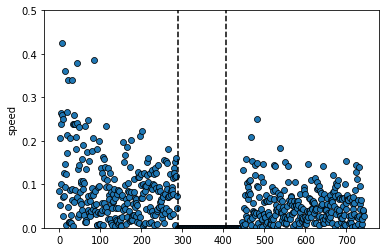

In [40]:
# Limit outliers
plt = sns.scatterplot(x=range(len(ndat)) ,y=ndat['speed'], edgecolor="black")
plt.axvline(289, ls='--', color='black')
plt.axvline(407, ls='--', color='black')
plt.set_ylim([0, .5])